# Run Q3Dfit from this Jupyter Notebook in a suitable environment.

<h3><font color='teal'>Installation of the environment and the package are described <a href="https://q3dfit.readthedocs.io/">here</a>. </font></h3>

This Jupyter notebook allows you to run Q3Dfit, a PSF decomposition and spectral analysis package tailored for JWST NIRSpec and MIRI IFU observations. 

Q3Dfit is developed as a science-enabling data product by the Early Release Science Team #1335 Q3D. You can find more information about this ERS program **Q3D** [here](https://wwwstaff.ari.uni-heidelberg.de/dwylezalek/q3d.html) and [here](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1335).

The software is based on the existing package IFSFIT developed by Dave Rupke (see [ADS link](https://ui.adsabs.harvard.edu/abs/2017ApJ...850...40R/abstract)).

The following notebook will guide you through the initialization procedure and will then perform the analysis. 

## Table of Contents

* [1. Initialization](#chapter1)
    * [1.1. Setting up the directory tree](#chapter1_1)
    * [1.2. Setting up the fitting parameters](#chapter1_2)        
* [2. Run Q3Dfit](#chapter2)
* [3. Run plotting script (q3da)](#chapter3)


<font color='red'>We need to decide where the makeqsotemplate functionality goes. </font>

## 1. Initialization <a class="anchor" id="chapter1"></a>

In [1]:
# unless you are running this python notebook from the directory where q3dfit is installed, you need to point the
# path to the package in order to import it. 
import sys
# add path to the installation directory
sys.path.append("/Users/nadia/mypython")
import q3dfit

In [ ]:
import os.path
import numpy as np
from q3dfit.common.questfit_readcf import readcf

### 1.1. Setting up the directory tree <a class="anchor" id="chapter1_1"></a>

Define the directories in which your data cube(s) that you want to analyse are stored and the output directories. We recommend creating a working directory that you name after your target, in which all outputs from Q3Dfit will be saved. 

In [2]:
# Input files
infile = '../test/test_questfit/22128896_mock_cube.fits'
cfinfile = '../test/test_questfit/22128896.cf'

# Output directories/files
outdir = ''
logfile = outdir+'test_questfit_fitlog.txt'
path_to_npy_file = outdir # path for initproc.npy



Some general information about your cube:

In [3]:
ncols = 1 # number of columns
nrows = 1 # number of rows
platescale = 0.3

fitrange = np.array([5.422479152679443, 29.980998992919922])  # micron

if not os.path.isfile(infile): 
    print('Data cube not found.')
if not os.path.isfile(cfinfile):
    print('Configuration file not found.')
else:
    config_file = readcf(cfinfile)

In [4]:
dict_argsreadcube = {'wmapext': None,
                    'wavext': 4,
                    'waveunit_in': 'Angstrom',
                    'fluxunit_in': 'Jy'}
zerodq = True   # put all dq to good (0)

### 1.2. Setting up the fitting parameters <a class="anchor" id="chapter1_2"></a>

What lines do you want to fit? You can choose from the linelist <font color='red'>provide reference here</font>.

In [5]:
lines = ['H2_00_S5', '[ArII]6.99', '[ArIII]8.99', '[NeII]12.81', 
         '[NeIII]15.56', 'H2_00_S3', 'H2_00_S1', '[SIII]18.71']

How many components do you want to be fitted to the emission lines?

In [6]:
maxncomp = 1

In [7]:
# Initialize line ties, n_comps, z_inits, and sig_inits.
linetie = dict()
ncomp = dict()
zinit_gas = dict()
siginit_gas = dict()
for i in lines:
    linetie[i] = '[NeII]12.81'
    ncomp[i] = np.full((ncols,nrows),maxncomp)
    zinit_gas[i] = np.full((ncols,nrows,maxncomp),0.)
    siginit_gas[i] = np.full(maxncomp, 1000.) #0.1) #1000.)
    zinit_stars=np.full((ncols,nrows),0.0)
siginit_stars = 100
maskwidths_def = 2000 # half-width in km/s for emission line masking during the continuum fit

In [8]:
zsys_gas = 0.0
siglim_gas = np.array([5., 4000.])

For a description of continuum fitting parameters in the .cf file, please see the documentation: 
https://q3dfit.readthedocs.io/en/latest/

In [24]:
fcncontfit = 'questfit'
argscontfit = dict()
argscontfit['config_file'] = cfinfile
argscontfit['models_dictionary'] = {}
argscontfit['template_dictionary'] = {}
argscontfit['outdir'] = outdirFor a description of continuum fitting parameters in the .cf file, please see the documentation: 
https://q3dfit.readthedocs.io/en/latest/

One dictionary must be defined for a line plot to appear. `argspltlin1` holds the options for the first line plot, and `argspltlin2` is for the second. Parameter options are fed in as keyword/data pairs.

Required keywords in each dictionary:
* `nx`: Number of subplots in the horizontal direction
* `ny`: Number of subplots in the vertical direction
* Options for centerting the plot:
    - `line`: a string list of line labels
    - `center_obs`: a float list of wavelengths of each subplot center, in the observed (plotted) frame
    - `center_rest`: a float list of wavelengths of each subplot center, in the rest frame, which are converted to obs. frame

Optional keywords:
* `size`: float list of widths in wavelength space of each subplot; if not specified, default is 300 $Å$
* `IR`: set to `True` to use infrared-style plot

In [25]:
argspltlin1 = {'nx': 3,
               'ny': 2,
               'line': ['[ArII]6.99', '[ArIII]8.99', '[NeII]12.81', 
                        '[NeIII]15.56', 'H2_00_S1', '[SIII]18.71'],
               'size': [3., 3., 3., 3., 3., 3.],
               'IR': True}

The following cell will create the initialisation structure. **Do not change anything in this cell.** 

In [26]:
initproc = { \
            # Required pars
            'fcninitpar': 'parinit',
            'fitran': fitrange,
            'infile': infile,
            'label': config_file['source'][0].replace('.ideos','').replace('.npy', ''),
            'lines': lines,
            'linetie': linetie,
            'maxncomp': maxncomp,
            'ncomp': ncomp,
            'outdir': outdir,
            'zinit_stars': zinit_stars,
            'zinit_gas': zinit_gas,
            'zsys_gas': zsys_gas,
            # Optional pars
            'fcncontfit': fcncontfit,            
            'argscontfit': argscontfit,
            'argspltlin1': argspltlin1,
            'fcncheckcomp': 'checkcomp',
            'maskwidths_def': maskwidths_def,
            'logfile': logfile,
            'siglim_gas': siglim_gas,
            'siginit_gas': siginit_gas,
            'siginit_stars': siginit_stars,
            'zerodq': zerodq,
            'argsreadcube': dict_argsreadcube
           }

If you want to run `q3dfit` in batch mode, run this cell, which saves initproc to an `npy` file. In your python command line, read in that `npy` file with
<pre><code>import numpy as np
initproc = np.load('path/to/the/npy/file/initproc.npy',allow_pickle=True)</code></pre>
and then run `q3dfit` with 
<pre><code>from q3dfit.common.q3df
import q3df q3df(initproc[()],cols=cols,rows=rows)</code></pre>

In [19]:
initproc_npy = 'initproc.npy'
np.save(path_to_npy_file+initproc_npy,initproc)

## 2. Run Q3Dfit <a class="anchor" id="chapter2"></a>

In [27]:
# This may be unique to the user, insert your path to the q3dfit/ folder here
import sys
if '../../' not in sys.path:
    sys.path.append('../../')

from q3dfit.common.q3df import q3df
from q3dfit.common.q3da import q3da

In [28]:
cols = [1]
rows = [1]

In [29]:
q3df(initproc, cols=cols, rows=rows, quiet=False)

FITLOOP: First call to FITSPEC
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        0.02023400 +/- 2.5127e-04 (1.24%) (init = 0.1)
    blackbody500a:         0.00137735 +/- 1.9546e-04 (14.19%) (init = 0.1)
    blackbody500T:         279.419345 +/- 8.11906561 (2.91%) (init = 500)
    blackbody500_ext_Av:   0.85467785 +/- 0.15141491 (17.72%) (init = 0)
    blackbody500_abs_tau:  0.71293644 +/- 0.24422912 (34.26%) (init = 0)
    blackbody50a:          0.00868952 +/- 0.00364542 (41.95%) (init = 0.1)
    blackbody50T:          104.622482 +/- 3.57455989 (3.42%) (init = 50)
    blackbody50_ext_Av:    2.4727e-18 +/- 0.31112261 (12582452664609781760.00%) (init = 0)
    blackbody50_abs_tau:   1.4344e-24 +/- 128.999104 (8993079356353537478899007488.00%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(blackbody50a, blackbody50_ext_Av)          = -1.000
    C(blackbody500a, blackbody500_ext_Av)        = -0.973
    C(blackbody50T, blackbody50_ext_Av)          =  0.948
   

## 3. Run plotting script (q3da) <a class="anchor" id="chapter3"></a>

CUBE: No wavelength units in header; assuming micron.
CUBE: No flux units in header; assuming MJy/sr
Column 1 of 1
    Row 1 of 1


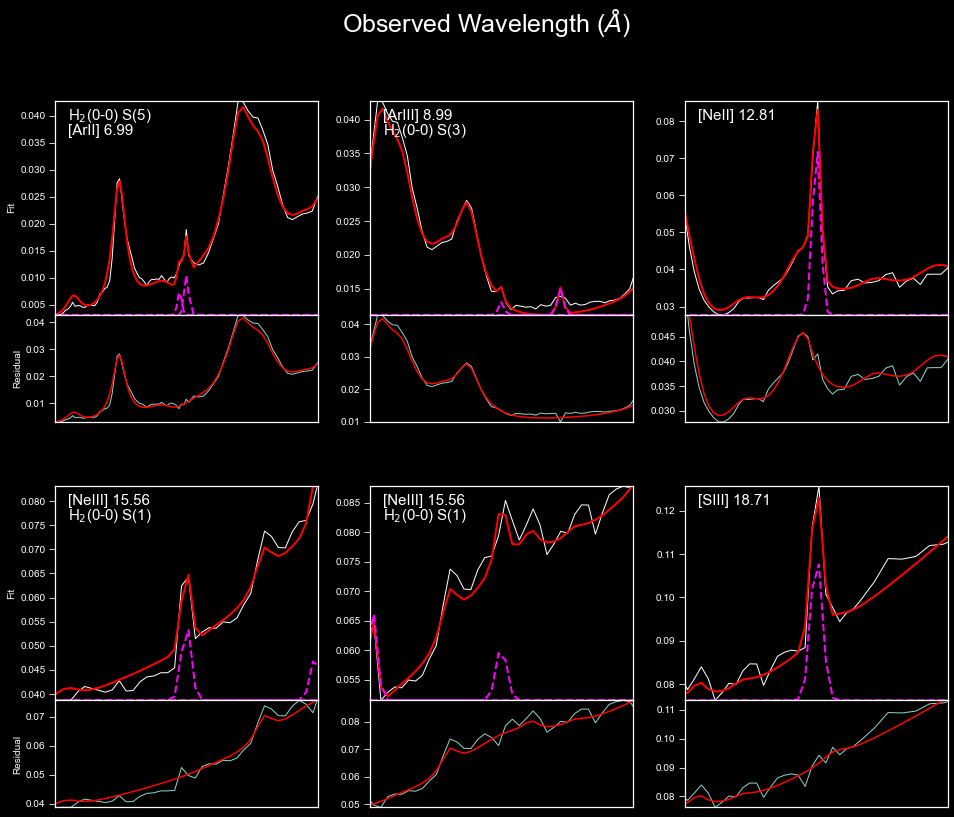

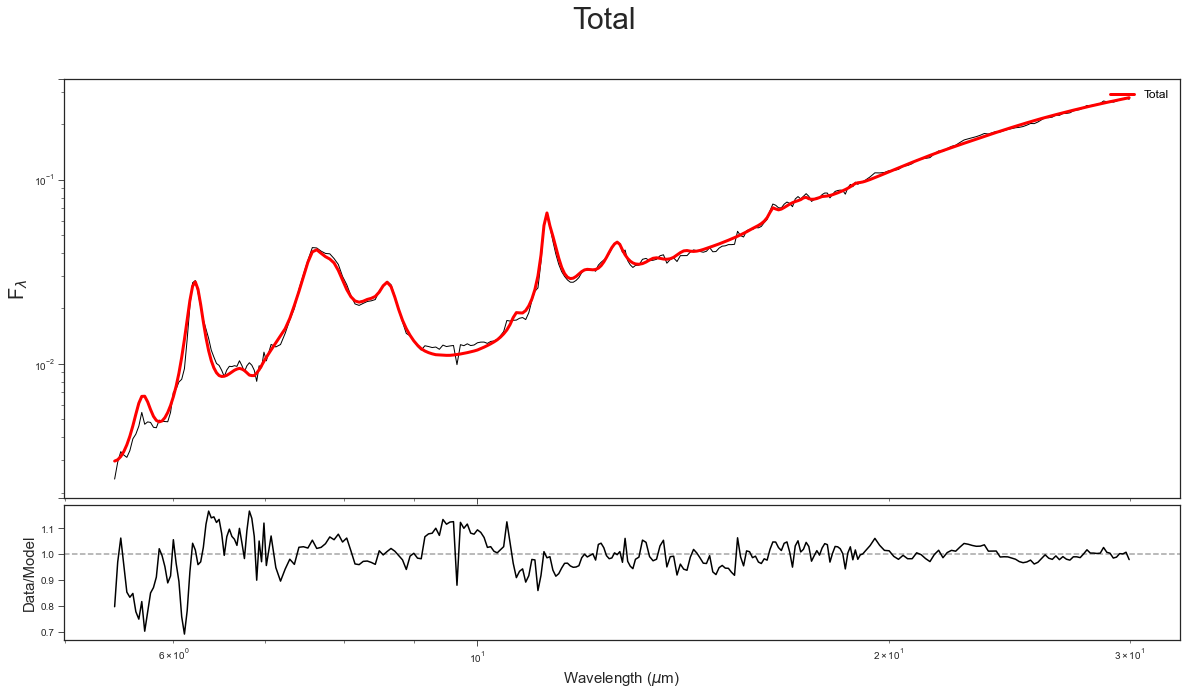

In [30]:
%matplotlib inline
q3da(initproc, cols=cols, rows=rows, quiet=False)